In [1]:
import dask
from dask.distributed import Client, progress
from dask.distributed import wait
from dask.delayed import delayed
import dask.dataframe as dd
import seaborn as sns
IPADDR = "125.20.34.42"
_client = IPADDR + str(":8786")
client = dask.distributed.Client(n_workers=2, threads_per_worker=2, memory_limit='3GB')
client

/Users/rashminagpal/anaconda3/lib/python3.7/site-packages/distributed/dashboard/core.py:74: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:64572 Dashboard: http://127.0.0.1:64573/status,Cluster Workers: 2 Cores: 4 Memory: 6.00 GB


In [2]:
df = dd.read_csv("nyc-yellow-taxi-2015-sample-data/test_2015.csv",parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'],storage_options={'anon':True})

In [3]:

df = client.persist(df)
progress(df)

VBox()

In [4]:
df

,RateCodeID,RatecodeID,VendorID,dropoff_latitude,dropoff_longitude,extra,fare_amount,improvement_surcharge,mta_tax,passenger_count,payment_type,pickup_latitude,pickup_longitude,store_and_fwd_flag,tip_amount,tolls_amount,total_amount,tpep_dropoff_datetime,tpep_pickup_datetime,trip_distance
npartitions=4,,,,,,,,,,,,,,,,,,,,
,float64,float64,int64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,object,float64,float64,float64,datetime64[ns],datetime64[ns],float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [5]:
df.dtypes

RateCodeID                      float64
RatecodeID                      float64
VendorID                          int64
dropoff_latitude                float64
dropoff_longitude               float64
extra                           float64
fare_amount                     float64
improvement_surcharge           float64
mta_tax                         float64
passenger_count                   int64
payment_type                      int64
pickup_latitude                 float64
pickup_longitude                float64
store_and_fwd_flag               object
tip_amount                      float64
tolls_amount                    float64
total_amount                    float64
tpep_dropoff_datetime    datetime64[ns]
tpep_pickup_datetime     datetime64[ns]
trip_distance                   float64
dtype: object

In [6]:
df.head()

,RateCodeID,RatecodeID,VendorID,dropoff_latitude,dropoff_longitude,extra,fare_amount,improvement_surcharge,mta_tax,passenger_count,payment_type,pickup_latitude,pickup_longitude,store_and_fwd_flag,tip_amount,tolls_amount,total_amount,tpep_dropoff_datetime,tpep_pickup_datetime,trip_distance
0,1.0,NaN,1,40.782337,-73.972160,0.0,5.0,0.3,0.5,1,2,40.789295,-73.966629,N,0.0,0.0,5.8,2015-01-09 12:58:40,2015-01-09 12:54:55,0.50
1,1.0,NaN,1,40.720490,-73.945465,0.5,12.5,0.3,0.5,1,1,40.723850,-73.992561,N,2.0,0.0,15.8,2015-01-13 23:19:17,2015-01-13 23:09:04,3.60
2,1.0,NaN,1,40.721367,-73.994781,0.0,14.5,0.3,0.5,2,2,40.749100,-73.991959,N,0.0,0.0,15.3,2015-01-25 17:37:55,2015-01-25 17:17:28,2.30
3,1.0,NaN,1,0.000000,0.000000,1.0,4.0,0.3,0.5,1,1,0.000000,0.000000,N,1.0,0.0,6.8,2015-01-22 19:00:38,2015-01-22 18:57:09,0.40
4,1.0,NaN,2,40.737110,-73.998177,0.0,4.5,0.3,0.5,1,1,40.733742,-73.990379,N,1.7,0.0,7.0,2015-01-17 18:16:01,2015-01-17 18:11:48,0.48


In [7]:
%time

len(df)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 33.9 µs


1446517

In [8]:
%time

df.passenger_count.sum().compute()

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 10 µs


2433648

#### Computing average trip distance grouped by passenger count

In [9]:
df.groupby(df.passenger_count).trip_distance.mean().compute()

passenger_count
0     2.129791
1    16.276604
2     3.196158
3     3.106862
4     3.139135
5     3.063591
6     2.978559
7     2.210000
Name: trip_distance, dtype: float64

##### From above computation, we can analyze that single and double person rides go for longer distances on average.

##### Eliminating fares which are negative

In [10]:
df.loc[df['fare_amount']<0].shape

(Delayed('int-2ac96752-5421-46b9-85ba-c346a8e83978'), 20)

In [11]:
df=df.loc[df['fare_amount']>=0]
df.shape

(Delayed('int-e360c20a-0b2a-426b-899b-207280c049a7'), 20)

##### Removing those rows where the tip amount is zero

In [12]:
df2 = df[(df.tip_amount > 0) & (df.fare_amount > 0)]

In [13]:
df2 = df2.assign(tip_fraction = df2.tip_amount/df2.fare_amount)

#### Group df.tpep_pickup_datetime by dayOfWeek and hour

In [15]:
dayofweek = df2.groupby(df2.tpep_pickup_datetime.dt.dayofweek).tip_fraction.mean() 
hour = df2.groupby(df2.tpep_pickup_datetime.dt.hour).tip_fraction.mean()

dayofweek, hour = client.persist([dayofweek, hour])
progress(dayofweek, hour)

VBox()

In [16]:
from bokeh.plotting import figure, output_notebook, show

In [19]:
output_notebook()

fig = figure(title='Tip Fraction',
             x_axis_label='Hour of day',
             y_axis_label='Tip Fraction',
             height=300)
fig.line(x=hour.index.compute(), y=hour.compute(), line_width=3)
fig.y_range.start = 0

show(fig)

Loading BokehJS ...

##### From above graph, we can interpret that New Yorkers are generally pretty generous, tipping around 20%-25% on average. We can also notice that they become very generous at 4am, tipping an average of 38%.

#### Trip Fare Distribution

Text(0.5, 1.0, 'Distribution of Trip Fare')

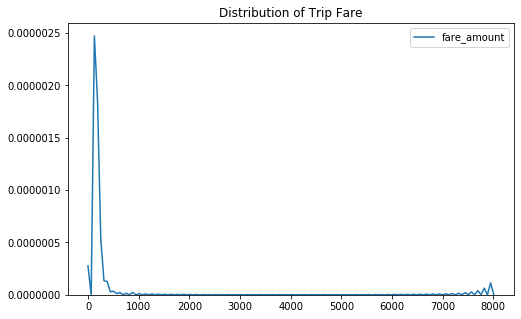

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
plt.figure(figsize=(8,5))
sns.kdeplot(df['fare_amount']).set_title("Distribution of Trip Fare")

#### Let us look at Geographical Features and their relationship with Fare Amount

###### Distribution of Pickup and Dropoff Lat Lng

In [24]:
print("Range of Pickup Latitude is ", (min(df['pickup_latitude']),max(df['pickup_latitude'])))

Range of Pickup Latitude is  (0.0, 60.68658065795898)


In [25]:
print("Range of Dropoff Latitude is ", (min(df['dropoff_latitude']),max(df['dropoff_longitude'])))

Range of Dropoff Latitude is  (0.0, 0.0)


In [26]:
print("Avg trip distance (in miles) when there are zero passengers",np.mean(df.loc[df['passenger_count']==0,'trip_distance'].values))

Avg trip distance (in miles) when there are zero passengers dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>


In [27]:
boundary={'min_lng':-74.263242,
              'min_lat':40.573143,
              'max_lng':-72.986532, 
              'max_lat':41.709555
         }

In [28]:
df['pickup_latitude_round3']=df['pickup_latitude'].apply(lambda x:round(x,3))
df['pickup_longitude_round3']=df['pickup_longitude'].apply(lambda x:round(x,3))
df['dropoff_latitude_round3']=df['dropoff_latitude'].apply(lambda x:round(x,3))
df['dropoff_longitude_round3']=df['dropoff_longitude'].apply(lambda x:round(x,3))

/Users/rashminagpal/anaconda3/lib/python3.7/site-packages/dask/dataframe/core.py:3044: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('pickup_latitude', 'float64'))

  warnings.warn(meta_warning(meta))
/Users/rashminagpal/anaconda3/lib/python3.7/site-packages/dask/dataframe/core.py:3044: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, 

##### Average fare from latitude vs longitude pickup round 

In [29]:
pickup_fare_amount=df.groupby(['pickup_latitude_round3','pickup_longitude_round3'])['fare_amount'].mean().reset_index().rename(columns={'fare_amount':'avg_fare'})
pickup_fare_amount.head()

,pickup_latitude_round3,pickup_longitude_round3,avg_fare
0,0.000,0.000,13.983584
1,36.908,-74.000,8.000000
2,37.367,-121.915,2.000000
3,37.368,-121.914,1.700000
4,39.382,-74.495,110.000000


In [28]:
df[(df.pickup_latitude==0) | (df.pickup_longitude)==0 | (df.dropoff_latitude==0)|(df.dropoff_longitude==0)].shape

(Delayed('int-f1556e44-01ed-44e8-ba8e-eb56c899fbbc'), 20)

#### Groupby day of week

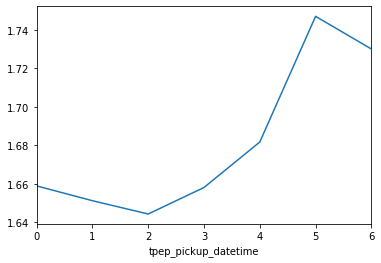

In [38]:
(df.passenger_count
   .groupby(df.index.dayofweek)
   .mean()
   .compute()
   .plot())

#### Resample by day

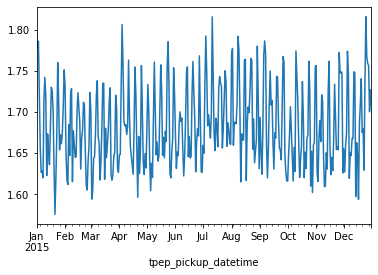

In [40]:
(df.passenger_count
   .resample('1d')
   .mean()
   .compute()
   .plot())

In [41]:
s = client.persist(df.passenger_count.rolling(10).mean())

In [42]:
s

Dask Series Structure:
npartitions=4
2015-01-01 00:01:19.000000000    float64
2015-03-23 23:54:23.885702400        ...
2015-06-09 07:33:47.400000000        ...
2015-09-02 13:26:41.000000000        ...
2015-12-31 23:59:02.000000000        ...
Name: passenger_count, dtype: float64
Dask Name: mean, 4 tasks

#### From above analysis, we can observe strong periodic signal which signifies that the number of passengers is high on weekends.

In [53]:
import pandas as pd
from dask.diagnostics import ProgressBar
payments = pd.Series({1: 'Credit Card',
                          2: 'Cash',
                          3: 'No Charge',
                          4: 'Dispute',
                          5: 'Unknown',
                          6: 'Voided trip'})
npayments = payments.to_frame()
npayments.rename(columns={0: "payment_name"})

,payment_name
1,Credit Card
2,Cash
3,No Charge
4,Dispute
5,Unknown
6,Voided trip


In [54]:
df2 = df.merge(npayments, left_on='payment_type', right_index=True)

In [59]:
df2.rename(columns={0: 'payment_name'})

,RateCodeID,RatecodeID,VendorID,dropoff_latitude,dropoff_longitude,extra,fare_amount,improvement_surcharge,mta_tax,passenger_count,payment_type,pickup_latitude,pickup_longitude,store_and_fwd_flag,tip_amount,tolls_amount,total_amount,tpep_dropoff_datetime,tpep_pickup_datetime,trip_distance,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,payment_name
npartitions=4,,,,,,,,,,,,,,,,,,,,,,,,,
,float64,float64,int64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,object,float64,float64,float64,datetime64[ns],datetime64[ns],float64,float64,float64,float64,float64,object
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [64]:
df2.columns = ['RateCodeID',               'RatecodeID',
                       'VendorID',         'dropoff_latitude',
              'dropoff_longitude',                    'extra',
                    'fare_amount',    'improvement_surcharge',
                        'mta_tax',          'passenger_count',
                   'payment_type',          'pickup_latitude',
               'pickup_longitude',       'store_and_fwd_flag',
                     'tip_amount',             'tolls_amount',
                   'total_amount',    'tpep_dropoff_datetime',
           'tpep_pickup_datetime',            'trip_distance',
         'pickup_latitude_round3',  'pickup_longitude_round3',
        'dropoff_latitude_round3', 'dropoff_longitude_round3',
               'payment_name']

In [62]:
df2.head()

,RateCodeID,RatecodeID,VendorID,dropoff_latitude,dropoff_longitude,extra,fare_amount,improvement_surcharge,mta_tax,passenger_count,...,tolls_amount,total_amount,tpep_dropoff_datetime,tpep_pickup_datetime,trip_distance,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,payment_name
0,1.0,NaN,1,40.782337,-73.972160,0.0,5.0,0.3,0.5,1,...,0.0,5.8,2015-01-09 12:58:40,2015-01-09 12:54:55,0.50,40.789,-73.967,40.782,-73.972,Cash
2,1.0,NaN,1,40.721367,-73.994781,0.0,14.5,0.3,0.5,2,...,0.0,15.3,2015-01-25 17:37:55,2015-01-25 17:17:28,2.30,40.749,-73.992,40.721,-73.995,Cash
7,1.0,NaN,2,40.753906,-73.977493,0.5,4.5,0.3,0.5,3,...,0.0,5.8,2015-01-10 21:33:44,2015-01-10 21:30:21,0.69,40.762,-73.975,40.754,-73.977,Cash
9,2.0,NaN,2,40.764610,-73.979149,0.0,52.0,0.3,0.5,1,...,0.0,52.8,2015-01-31 16:23:13,2015-01-31 15:39:10,16.87,40.649,-73.785,40.765,-73.979,Cash
15,1.0,NaN,2,40.738300,-73.982002,0.5,12.0,0.3,0.5,1,...,0.0,13.3,2015-01-10 21:26:13,2015-01-10 21:11:31,2.96,40.766,-73.991,40.738,-73.982,Cash


In [63]:
df2.groupby(df2.payment_name).tip_amount.mean().compute()

payment_name
Cash           0.000204
Credit Card    2.712341
Dispute        0.000691
No Charge      0.000690
Name: tip_amount, dtype: float64

##### We see from this analysis, that while the average tip for a credit card transaction is 2.71 USD, the average tip for a cash transaction is very close to zero. At first glance it seems like cash tips aren’t being reported.

#####  To investigate further lets compute the Pearson correlation between paying cash and having zero tip.

In [65]:
zero_tip = df2.tip_amount == 0
cash     = df2.payment_name == 'Cash'

dd.concat([zero_tip, cash], axis=1).corr().compute()

/Users/rashminagpal/anaconda3/lib/python3.7/site-packages/dask/dataframe/multi.py:1059: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indexes of each dataframes are 
 aligned. This assumption is not generally safe.
  "Concatenating dataframes with unknown divisions.\n"


,tip_amount,payment_name
tip_amount,1.000000,0.943704
payment_name,0.943704,1.000000
